In [1]:
import pandas as pd
import copy
from   IPython.display import display, HTML, clear_output

pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
%load_ext autoreload
%autoreload 2

# A linear-quadratic-Gaussian control problem

Consider system dynamics
\begin{equation}
    d X_{t}= (b+c\,u_{t})\,d t+\tilde{\Sigma}\,d W_{t}\,,  \quad X_0\in\mathbb R,
\end{equation}
where $b$ is a constant drift, $c>0$ scales the linear impact of an agent on the system, and $\tilde{\Sigma} > 0$ is the variance of the observation noise. The agent maximizes the LQ criterion
\begin{equation}
\mathbb{E}\left[X_{T}-\alpha\,X_{T}^{2}-\phi\,\int_{0}^{T}u_{t}^{2}\,d t\right]\,,
\end{equation}
where $\phi>0$ scales the running quadratic penalty and  $\alpha>0$ scales the terminal quadratic penalty. 

When the drift is known and fixed, the OC problem can be solved with standard methods, and is 
\begin{align}\label{eq:control perfect knowledge}
    u^{\star}=\frac{c}{2\,\phi}\,\left(2\,A\left(t\right)\,x+B\left(t\right)+1\right)\,,
\end{align}
where $A$ and $B$ solve the ODE system
\begin{align}\label{eq:ODE system perfect knoweldge LQ}
\begin{cases}
-A^{'}\left(t\right)=\frac{c\,A\left(t\right)^{2}}{2\,\phi}\\
-B^{'}\left(t\right)=2\,\mu\,A\left(t\right)+\frac{c^{2}\,A\left(t\right)\,\left(B\left(t\right)+1\right)}{\phi}\,.
\end{cases}
\end{align}

In [3]:
###############################
# Matrix Riccati ODE solver   #
###############################
def solve_riccati_implicit(
        T, nb_t, d,
        Q, Y, U, PT
):
    dt = T / (nb_t - 1)

    Pts = np.empty([nb_t, d, d])
    Pts[-1, ...] = PT

    for t in range(nb_t - 2, -1, -1):
        if d == 1:
            Ptplusdt = np.array([np.squeeze(Pts[t + 1, ...])])
        else:
            Ptplusdt = np.squeeze(Pts[t + 1, ...])

        P = Ptplusdt.copy()
        for i in range(10):
            diff_big_mat = np.eye(d * d) + dt * (np.kron(Y.T, np.eye(d)) + np.kron(np.eye(d), Y.T) + np.kron(
                np.eye(d),
                np.transpose(U @ P)
            ) + np.kron(P @ U, np.eye(d)))
            err = P + dt * (Q + Y.T @ P + P @ Y + P @ U @ P) - Ptplusdt
            err = np.linalg.inv(diff_big_mat) @ err.flatten()
            P = P - err.reshape(d, d)
        Pts[t, ...] = P.copy()

    return Pts


#####################
# LQG ODE solvers   #
#####################
def solver_BC(phi, As, mu, Sigma, c, dt):
    d = np.shape(As)[1]
    nb_t = np.shape(As)[0]

    Bs = np.empty((nb_t, d))
    Cs = np.empty((nb_t, d))

    Bs[-1, ...] = np.zeros(d)
    Cs[-1, ...] = np.zeros(d)

    I = np.eye(d)

    invphi = np.linalg.inv(phi)

    for t in range(nb_t - 2, -1, -1):
        Bs[t, ...] = Bs[t + 1, ...] + dt * (2 * mu.T @ As[t + 1, ...] + c * c * As[t + 1, ...] @ invphi @ Bs[t + 1, ...])
        Cs[t, ...] = Cs[t + 1, ...] + dt * (mu.T @ (Bs[t + 1, ...] + 1) + 0.25 * c * c * (Bs[t + 1, ...] + 1).T @ invphi @ (
                Bs[t + 1, ...] + 1) + np.trace(Sigma @ As[t + 1, ...]))

    return Bs, Cs

# Solve the control problem
def solve_control_problem_1d(T, nb_t, b, c, phi, alpha, sigma):
    At = solve_riccati_implicit(T, nb_t, 1,  np.array([[0]]),  np.array([[0]]),  -np.array([[c * c * phi**-1]]), -np.array([[alpha]]),)
    Bt, Ct = solver_BC(np.array([[phi]]), At, np.array([[b]]), np.array([[sigma]]), c, T/nb_t,)
    return At, Bt, Ct

# Control setup

In [4]:
# Example:
T     = 1
nb_t  = 1000
c     = 1 # linear permanent impact
b     = 1 # drift
sigma = 5
phi   = 1 # running penalty
alpha = .3 # terminal penalty

At, Bt, Ct = solve_control_problem_1d(T, nb_t, b, c, phi, alpha, sigma)

In [5]:
np.shape(At)

(1000, 1, 1)

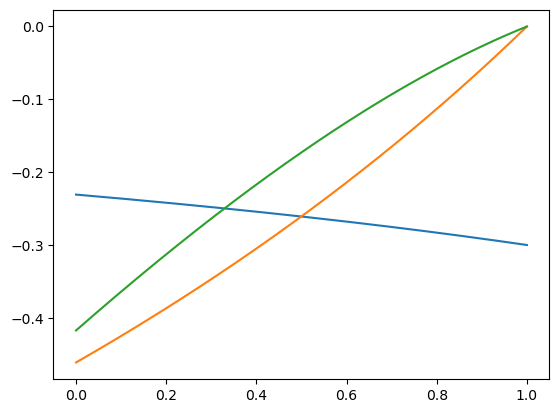

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, T, nb_t), At[:,0,0])
ax.plot(np.linspace(0, T, nb_t), Bt[:,0])
ax.plot(np.linspace(0, T, nb_t), Ct[:])

# DGM solver

In [7]:
from model.pde.Sampler import Sampler
from ADGM import train_pde_solver_adgm, ADGMSolverConfig, ADGMSolver
from model.approximation.FunctionModel import MLP
from model.approximation.Preprocesing import StandardScale
from torch_util import DEVICE

from model.ImpactModel import DeterministicImpact
from plot_utils import compare_control_results

In [8]:
''' Control parameters ''' 
x_low, x_high, x0 = 1, 13, 5 # domain of system
lr                = 1e-3     # learning rate
n_training        = 20000    # number of steps

''' Control parameters '''   
config      = ADGMSolverConfig(phi=phi, alpha=alpha, sigma=sigma, rc_exponent=2, tc_exponent=2)

''' ADGM specs '''
n_interior_time   = 2 ** 5
n_interior_space  = 2 ** 5
n_terminal        = 2 ** 12
n_random_interior = 2 ** 8
n_random_terminal = 2 ** 8
weight_every      = 5000
save_every        = 5000
directory_res     = f"res"

''' Samplers & other objects '''
batch_sizes = n_interior_time, n_interior_space, n_terminal, n_random_interior, n_random_terminal
sampler     = Sampler(terminal_time=T, x_low=x_low, x_high=x_high)
drift       = DeterministicImpact(impact_function=lambda x, u: c * u)

In [9]:
################################
####  DGM neural networks   ####
################################
value_function    = MLP(input_dim=1, n_layers=1, hidden_dim=20, output_dim=1,
                             input_transform=StandardScale(),).to(DEVICE)

control           = MLP(input_dim=1, n_layers=1, hidden_dim=20, output_dim=1, 
                             input_transform=StandardScale(),).to(DEVICE)

####################
####  Optimizer ####
####################
optimizer         = torch.optim.Adam([*value_function.parameters(), 
                                            *control.parameters()], 
                                            lr=lr, eps=1e-8)

solver            = ADGMSolver(drift, value_function, control,
                                  sampler, config=config, 
                                  pde_optimizer=optimizer)

solver.fit_data_transforms(batch_sizes, 0.0)

losses_DGM   = train_pde_solver_adgm(solver, n_training, batch_sizes, directory_res, 
                                     save_every, weight_every,
                                     scheduler=None, reweight=False) #lr_scheduler_ilqr

hist_losses_DGM = np.array([np.sum([losses_DGM[i].mse_dict[k] for k in ['Total', ]]) for i in range(len(losses_DGM))])

  0%|          | 0/20000 [00:00<?, ?it/s]

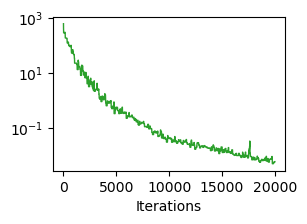

In [10]:
times = np.linspace(0, len(hist_losses_DGM), len(hist_losses_DGM), endpoint=False)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(times, pd.Series(hist_losses_DGM).rolling(100, min_periods=1).min(), color='tab:green', lw=1)
ax.set_xlabel('Iterations')
ax.set_yscale('log')

# Comparison

In [11]:
def get_optimal_control(As, Bs, Cs, phi, t, x, c):
    return 0.5 * c * np.linalg.inv(phi) @ (2 * As[t, ...] @ x + Bs[t, ...] + 1)

def get_control_results(
        dW,
        nb_t, T, phi, b, c, sigma, alpha,
        x0,
        At, Bt, Ct
):
    dt = T/nb_t

    ''' variables for control problem with perfect knowledge '''
    x, us = np.zeros(nb_t), np.zeros(nb_t)
    x[0] = x0

    for t in range(nb_t - 1):
        ''' compute optimal control '''
        us[t] = get_optimal_control(At, Bt, Ct, np.array([[phi]]), t, np.array([[x[t]]]), c)

        ''' update systems '''
        x[t + 1] = x[t] + b * dt + c * us[t] * dt + sigma * dW[t] * np.sqrt(dt)
    
    ''' Terminal values '''
    us[-1] = get_optimal_control(At, Bt, Ct, np.array([[phi]]), nb_t - 1, np.array([[x[-1]]]), c)

    ''' Compute performance '''
    perf = x - np.cumsum(dt * us * us * phi) - x0 - x[-1] * x[-1] * alpha
    
    return x, us, perf

def get_DGM_results(
        dW,
        nb_t, T, phi, b, c, sigma, alpha,
        x0,
        control_DGM
):
    dt = T/nb_t

    ''' variables for control problem with perfect knowledge '''
    x, us = np.zeros(nb_t), np.zeros(nb_t)
    x[0] = x0

    for t in range(nb_t - 1):
        ''' compute optimal control '''
        us[t] = control(torch.Tensor([[t/nb_t]]), torch.Tensor([[x[t]]])).detach().numpy()[0][0]

        ''' update systems '''
        x[t + 1] = x[t] + b * dt + c * us[t] * dt + sigma * dW[t] * np.sqrt(dt)
    
    ''' Terminal values '''
    us[-1] = control(torch.Tensor([[T]]), torch.Tensor([[x[-1]]])).detach().numpy()[0][0]

    ''' Compute performance '''
    perf = x - np.cumsum(dt * us * us * phi) - x0 - x[-1] * x[-1] * alpha
    
    return x, us, perf #, #perf_nolearning[-1] 

In [12]:
np.random.seed(42)

recompute_results = False

''' Brownian sample '''
dW = np.random.normal(0, T, nb_t)

''' analytical '''
x_analytical, us_analytical, perf_analytical =  get_control_results(dW, nb_t, T, phi, b, c, sigma, alpha, x0, At, Bt, Ct)

''' DGM '''
x_dgm, us_dgm, perf_dgm =  get_DGM_results(dW, nb_t, T, phi, b, c, sigma, alpha, x0, control)

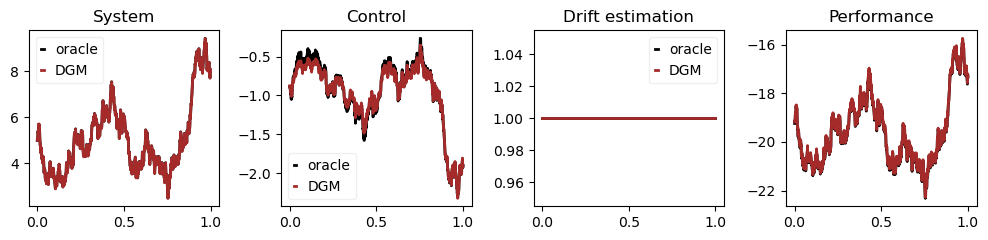

In [13]:
''' Uncomment for comparing results '''
_ = compare_control_results(np.linspace(0, T, nb_t), {
                            r'oracle'           : (x_analytical, us_analytical, np.ones(nb_t)*b, perf_analytical), 
                            r'DGM'             : (x_dgm,  us_dgm, np.ones(nb_t)*b, perf_dgm),
                        }, ('k', 'brown', 'tan', 'gray', 'tab:green'))

# Transfer Learning

In [14]:
phi

1

In [15]:
new_phi = 2

lr      = 1e-4

In [16]:
#########################
####  New solution   ####
#########################
new_AIR_DGM_config    = ADGMSolverConfig(phi=new_phi, alpha=alpha, sigma=sigma, rc_exponent=2, tc_exponent=2)

# not a Xavier initialization
new_value_function    = copy.deepcopy(value_function)
new_control           = copy.deepcopy(control)

####################
####  Optimizer ####
####################
new_optimizer         = torch.optim.Adam([*new_value_function.parameters(), 
                                            *new_control.parameters()], 
                                            lr=lr, eps=1e-8)

new_solver            = ADGMSolver(drift, new_value_function, new_control,
                                   sampler, config=new_AIR_DGM_config, 
                                   pde_optimizer=new_optimizer)

solver.fit_data_transforms(batch_sizes, 0.0)

losses_DGM   = train_pde_solver_adgm(new_solver, n_training, batch_sizes, directory_res, 
                                     save_every, weight_every,
                                     scheduler=None, reweight=False) #lr_scheduler_ilqr

new_hist_losses_DGM = np.array([np.sum([losses_DGM[i].mse_dict[k] for k in ['Total', ]]) for i in range(len(losses_DGM))])

  0%|          | 0/20000 [00:00<?, ?it/s]

/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_61549/2330480310.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axes[0].legend('Xavier initialisation', 'Transfer Learning')
/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_61549/2330480310.py:12: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axes[1].legend('Xavier initialisation', 'Transfer Learning')


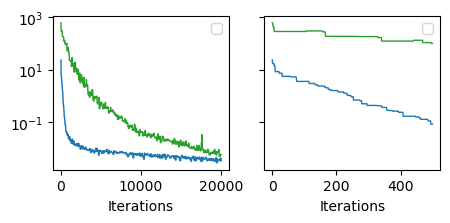

In [17]:
times = np.linspace(0, len(hist_losses_DGM), len(hist_losses_DGM), endpoint=False)
fig, axes = plt.subplots(1, 2, figsize=(5, 2), sharey=True)
axes[0].plot(times, pd.Series(hist_losses_DGM).rolling(100, min_periods=1).min(), color='tab:green', lw=1)
axes[0].plot(times, pd.Series(new_hist_losses_DGM).rolling(100, min_periods=1).min(), color='tab:blue', lw=1)
axes[0].legend('Xavier initialisation', 'Transfer Learning')
axes[0].set_xlabel('Iterations')
axes[0].set_yscale('log')

cutoff = 500
axes[1].plot(times[:cutoff], pd.Series(hist_losses_DGM[:cutoff]).rolling(100, min_periods=1).min(), color='tab:green', lw=1)
axes[1].plot(times[:cutoff], pd.Series(new_hist_losses_DGM[:cutoff]).rolling(100, min_periods=1).min(), color='tab:blue', lw=1)
axes[1].legend('Xavier initialisation', 'Transfer Learning')
axes[1].set_xlabel('Iterations')
axes[1].set_yscale('log')

# New simulation

In [18]:
np.random.seed(42)

recompute_results = False

''' Brownian sample '''
dW = np.random.normal(0, T, nb_t)

''' analytical '''
x_analytical, us_analytical, perf_analytical =  get_control_results(dW, nb_t, T, new_phi, b, c, sigma, alpha, x0, At, Bt, Ct)

''' adaptive '''
x_dgm_2, us_dgm_2, perf_dgm_2 =  get_DGM_results(dW, nb_t, T, new_phi, b, c, sigma, alpha, x0, new_control)

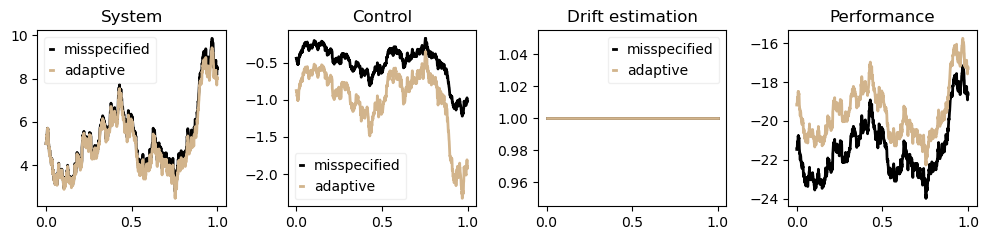

In [19]:
''' Uncomment for comparing results '''
_ = compare_control_results(np.linspace(0, T, nb_t), {
                            r'misspecified'           : (x_analytical, us_analytical, np.ones(nb_t)*b, perf_analytical), 
                            r'adaptive'             : (x_dgm,  us_dgm, np.ones(nb_t)*b, perf_dgm),
                        }, ('k', 'tan',))